# Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')
# import collect_data

## 1. COVID-19 Report

In [3]:
# Accessing data from database
engine = create_engine('sqlite:///covid.db')
cases_df = pd.read_sql('SELECT c.*, p.Population FROM case_data c LEFT JOIN pop_data p ON c.locality=p.Locality;',engine)

In [4]:
cases_df['report_date'] = pd.to_datetime(cases_df.report_date)
cases_df['total_cases'] = cases_df.total_cases.astype(int)
cases_df['hospitalizations'] = cases_df.hospitalizations.astype(int)
cases_df['deaths'] = cases_df.deaths.astype(int)
cases_df['Population'] = cases_df.Population.astype(int)
cases_df.replace({'vdh_health_district':"Thomas Jefferson"}, "Blue Ridge", inplace=True)

In [5]:
central=["Chesterfield", "Crater", "Chickahominy","Henrico","Piedmont","Richmond","Southside"]

eastern = ["Chesapeake", "Eastern Shore", "Hampton", "Norfolk", "Peninsula", "Portsmouth", "Three Rivers", 
           "Virginia Beach", "Western Tidewater"]

northern = ["Alexandria", "Arlington", "Fairfax", "Loudoun", "Prince William"]

northwest = ["Central Shenandoah", "Lord Fairfax", "Rappahannock", "Rappahannock Rapidan", "Blue Ridge"]

southwest = ["Alleghany", "Central Virginia", "Cumberland Plateau", "Lenowisco", "Mount Rogers", "New River",
            "Pittsylvania-Danville", "Roanoke", "West Piedmont"]
region_dict = {"central": central,
                 "eastern": eastern,
                 "northern": northern,
                 "northwest": northwest,
                 "southwest": southwest}
region_map = {val:key for key, lst in region_dict.items() for val in lst}
cases_df['region'] = cases_df.vdh_health_district.map(region_map)

In [6]:
cases_df.sort_values(['region','vdh_health_district', 'locality','report_date'],
              inplace=True,ascending=True,ignore_index=True)
cases_df.head(10)

,report_date,fips,locality,vdh_health_district,total_cases,hospitalizations,deaths,Population,region
0,2020-03-17,51041,Chesterfield,Chesterfield,4,2,0,343551,central
1,2020-03-18,51041,Chesterfield,Chesterfield,5,2,0,343551,central
2,2020-03-19,51041,Chesterfield,Chesterfield,6,3,0,343551,central
3,2020-03-20,51041,Chesterfield,Chesterfield,5,1,0,343551,central
4,2020-03-21,51041,Chesterfield,Chesterfield,7,1,0,343551,central
5,2020-03-22,51041,Chesterfield,Chesterfield,8,2,0,343551,central
6,2020-03-23,51041,Chesterfield,Chesterfield,9,2,0,343551,central
7,2020-03-24,51041,Chesterfield,Chesterfield,10,2,0,343551,central
8,2020-03-25,51041,Chesterfield,Chesterfield,11,2,0,343551,central
9,2020-03-26,51041,Chesterfield,Chesterfield,12,2,0,343551,central


In [7]:
cases_df[['prev_date','prev_total_cases','prev_hosp','prev_deaths']] = (cases_df
                                                                            .groupby(['region','vdh_health_district','locality'])\
                                                                            ['report_date','total_cases','hospitalizations','deaths']
                                                                            .apply(lambda grp: grp.shift(1)))

In [8]:
cases_df.fillna(0, inplace=True)

In [9]:
def get_case_count(row):
    counter = (row['total_cases'] - row['prev_total_cases'])
    if counter < 0:
        return 0
    return counter
def get_hos_count(row):
    counter = (row['hospitalizations'] - row['prev_hosp'])
    if counter < 0:
        return 0
    return counter
def get_death_count(row):
    counter = (row['deaths'] - row['prev_deaths'])
    if counter < 0:
        return 0
    return counter
cases_df['new_cases'] = cases_df.apply(lambda row: get_case_count(row), axis=1 )
cases_df['new_hosp'] = cases_df.apply(lambda row: get_hos_count(row), axis=1 )
cases_df['new_deaths'] = cases_df.apply(lambda row: get_death_count(row), axis=1 )

In [10]:
cases_df

,report_date,fips,locality,vdh_health_district,total_cases,hospitalizations,deaths,Population,region,prev_date,prev_total_cases,prev_hosp,prev_deaths,new_cases,new_hosp,new_deaths
0,2020-03-17,51041,Chesterfield,Chesterfield,4,2,0,343551,central,0,0.0,0.0,0.0,4.0,2.0,0.0
1,2020-03-18,51041,Chesterfield,Chesterfield,5,2,0,343551,central,2020-03-17 00:00:00,4.0,2.0,0.0,1.0,0.0,0.0
2,2020-03-19,51041,Chesterfield,Chesterfield,6,3,0,343551,central,2020-03-18 00:00:00,5.0,2.0,0.0,1.0,1.0,0.0
3,2020-03-20,51041,Chesterfield,Chesterfield,5,1,0,343551,central,2020-03-19 00:00:00,6.0,3.0,0.0,0.0,0.0,0.0
4,2020-03-21,51041,Chesterfield,Chesterfield,7,1,0,343551,central,2020-03-20 00:00:00,5.0,1.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,Patrick,West Piedmont,1391,110,43,17748,southwest,2021-06-15 00:00:00,1391.0,110.0,43.0,0.0,0.0,0.0
61309,2021-06-17,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-16 00:00:00,1391.0,110.0,43.0,2.0,1.0,0.0
61310,2021-06-18,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-17 00:00:00,1393.0,111.0,43.0,0.0,0.0,0.0
61311,2021-06-19,51141,Patrick,West Piedmont,1393,112,43,17748,southwest,2021-06-18 00:00:00,1393.0,111.0,43.0,0.0,1.0,0.0


In [11]:
cases_df['weekly_rolling_avg_cases'] = cases_df.new_cases.rolling(7).mean()

In [12]:
cases_df

,report_date,fips,locality,vdh_health_district,total_cases,hospitalizations,deaths,Population,region,prev_date,prev_total_cases,prev_hosp,prev_deaths,new_cases,new_hosp,new_deaths,weekly_rolling_avg_cases
0,2020-03-17,51041,Chesterfield,Chesterfield,4,2,0,343551,central,0,0.0,0.0,0.0,4.0,2.0,0.0,NaN
1,2020-03-18,51041,Chesterfield,Chesterfield,5,2,0,343551,central,2020-03-17 00:00:00,4.0,2.0,0.0,1.0,0.0,0.0,NaN
2,2020-03-19,51041,Chesterfield,Chesterfield,6,3,0,343551,central,2020-03-18 00:00:00,5.0,2.0,0.0,1.0,1.0,0.0,NaN
3,2020-03-20,51041,Chesterfield,Chesterfield,5,1,0,343551,central,2020-03-19 00:00:00,6.0,3.0,0.0,0.0,0.0,0.0,NaN
4,2020-03-21,51041,Chesterfield,Chesterfield,7,1,0,343551,central,2020-03-20 00:00:00,5.0,1.0,0.0,2.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,Patrick,West Piedmont,1391,110,43,17748,southwest,2021-06-15 00:00:00,1391.0,110.0,43.0,0.0,0.0,0.0,0.285714
61309,2021-06-17,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-16 00:00:00,1391.0,110.0,43.0,2.0,1.0,0.0,0.571429
61310,2021-06-18,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-17 00:00:00,1393.0,111.0,43.0,0.0,0.0,0.0,0.571429
61311,2021-06-19,51141,Patrick,West Piedmont,1393,112,43,17748,southwest,2021-06-18 00:00:00,1393.0,111.0,43.0,0.0,1.0,0.0,0.428571


In [14]:
test = cases_df.groupby("report_date").weekly_rolling_avg_cases.sum()

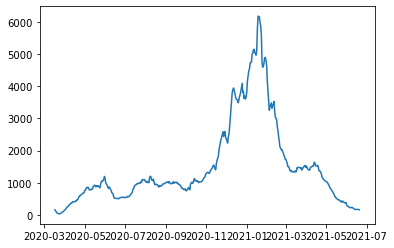

In [15]:
import matplotlib.pyplot as plt
plt.plot(test)

In [16]:
cases_df['rate_per_100000']=round(cases_df.weekly_rolling_avg_cases / cases_df.Population * 100000,3)

In [17]:
cases_df

,report_date,fips,locality,vdh_health_district,total_cases,hospitalizations,deaths,Population,region,prev_date,prev_total_cases,prev_hosp,prev_deaths,new_cases,new_hosp,new_deaths,weekly_rolling_avg_cases,rate_per_100000
0,2020-03-17,51041,Chesterfield,Chesterfield,4,2,0,343551,central,0,0.0,0.0,0.0,4.0,2.0,0.0,NaN,NaN
1,2020-03-18,51041,Chesterfield,Chesterfield,5,2,0,343551,central,2020-03-17 00:00:00,4.0,2.0,0.0,1.0,0.0,0.0,NaN,NaN
2,2020-03-19,51041,Chesterfield,Chesterfield,6,3,0,343551,central,2020-03-18 00:00:00,5.0,2.0,0.0,1.0,1.0,0.0,NaN,NaN
3,2020-03-20,51041,Chesterfield,Chesterfield,5,1,0,343551,central,2020-03-19 00:00:00,6.0,3.0,0.0,0.0,0.0,0.0,NaN,NaN
4,2020-03-21,51041,Chesterfield,Chesterfield,7,1,0,343551,central,2020-03-20 00:00:00,5.0,1.0,0.0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,Patrick,West Piedmont,1391,110,43,17748,southwest,2021-06-15 00:00:00,1391.0,110.0,43.0,0.0,0.0,0.0,0.285714,1.610
61309,2021-06-17,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-16 00:00:00,1391.0,110.0,43.0,2.0,1.0,0.0,0.571429,3.220
61310,2021-06-18,51141,Patrick,West Piedmont,1393,111,43,17748,southwest,2021-06-17 00:00:00,1393.0,111.0,43.0,0.0,0.0,0.0,0.571429,3.220
61311,2021-06-19,51141,Patrick,West Piedmont,1393,112,43,17748,southwest,2021-06-18 00:00:00,1393.0,111.0,43.0,0.0,1.0,0.0,0.428571,2.415


In [18]:
cases_df['rate_per_100000'].max()

282.039

In [19]:
cases_df.columns

Index(['report_date', 'fips', 'locality', 'vdh_health_district', 'total_cases',
       'hospitalizations', 'deaths', 'Population', 'region', 'prev_date',
       'prev_total_cases', 'prev_hosp', 'prev_deaths', 'new_cases', 'new_hosp',
       'new_deaths', 'weekly_rolling_avg_cases', 'rate_per_100000'],
      dtype='object')

In [20]:
new_df = cases_df[['report_date', 'fips', 'region', 'vdh_health_district', 'locality', 'Population', 
                   'total_cases', 'hospitalizations', 'deaths', 'new_cases', 'new_hosp', 
                   'new_deaths', 'weekly_rolling_avg_cases', 'rate_per_100000']]

In [21]:
new_df

,report_date,fips,region,vdh_health_district,locality,Population,total_cases,hospitalizations,deaths,new_cases,new_hosp,new_deaths,weekly_rolling_avg_cases,rate_per_100000
0,2020-03-17,51041,central,Chesterfield,Chesterfield,343551,4,2,0,4.0,2.0,0.0,NaN,NaN
1,2020-03-18,51041,central,Chesterfield,Chesterfield,343551,5,2,0,1.0,0.0,0.0,NaN,NaN
2,2020-03-19,51041,central,Chesterfield,Chesterfield,343551,6,3,0,1.0,1.0,0.0,NaN,NaN
3,2020-03-20,51041,central,Chesterfield,Chesterfield,343551,5,1,0,0.0,0.0,0.0,NaN,NaN
4,2020-03-21,51041,central,Chesterfield,Chesterfield,343551,7,1,0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,southwest,West Piedmont,Patrick,17748,1391,110,43,0.0,0.0,0.0,0.285714,1.610
61309,2021-06-17,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,2.0,1.0,0.0,0.571429,3.220
61310,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,0.0,0.0,0.0,0.571429,3.220
61311,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,1393,112,43,0.0,1.0,0.0,0.428571,2.415


In [22]:
def preprocess_case_df():
    """
    Preprocess the case_data from sql db and output as a df
    """
    
    # Accessing data from database
    engine = create_engine('sqlite:///covid.db')
    df = pd.read_sql('SELECT c.*, p.Population FROM case_data c LEFT JOIN pop_data p ON c.locality=p.Locality;',
                     engine)
    
    # change datatype
    df['report_date'] = pd.to_datetime(df.report_date)
    df['total_cases'] = df.total_cases.astype(int)
    df['hospitalizations'] = df.hospitalizations.astype(int)
    df['deaths'] = df.deaths.astype(int)
    df['Population'] = df.Population.astype(int)
    df.replace({'vdh_health_district':"Thomas Jefferson"}, "Blue Ridge", inplace=True)
    
    # add region
    central=["Chesterfield", "Crater", "Chickahominy","Henrico","Piedmont","Richmond","Southside"]
    eastern = ["Chesapeake", "Eastern Shore", "Hampton", "Norfolk", "Peninsula", "Portsmouth", "Three Rivers", 
           "Virginia Beach", "Western Tidewater"]
    northern = ["Alexandria", "Arlington", "Fairfax", "Loudoun", "Prince William"]
    northwest = ["Central Shenandoah", "Lord Fairfax", "Rappahannock", "Rappahannock Rapidan", "Blue Ridge"]
    southwest = ["Alleghany", "Central Virginia", "Cumberland Plateau", "Lenowisco", "Mount Rogers", "New River",
            "Pittsylvania-Danville", "Roanoke", "West Piedmont"]
    region_dict = {"central": central,
                 "eastern": eastern,
                 "northern": northern,
                 "northwest": northwest,
                 "southwest": southwest}
    region_map = {val:key for key, lst in region_dict.items() for val in lst}
    df['region'] = df.vdh_health_district.map(region_map)
    
    # get daily new nums
    df.sort_values(['region','vdh_health_district', 'locality','report_date'],
              inplace=True,ascending=True,ignore_index=True)
    df[['prev_total_cases','prev_hosp','prev_deaths']] = (df
                                                        .groupby(['region','vdh_health_district','locality'])\
                                                        ['total_cases','hospitalizations','deaths']
                                                        .apply(lambda grp: grp.shift(1)))
    df.fillna(0, inplace=True)
    def get_case_count(row):
        counter = (row['total_cases'] - row['prev_total_cases'])
        if counter < 0:
            return 0
        return counter
    def get_hos_count(row):
        counter = (row['hospitalizations'] - row['prev_hosp'])
        if counter < 0:
            return 0
        return counter
    def get_death_count(row):
        counter = (row['deaths'] - row['prev_deaths'])
        if counter < 0:
            return 0
        return counter
    df['new_cases'] = df.apply(lambda row: get_case_count(row), axis=1 )
    df['new_hosp'] = df.apply(lambda row: get_hos_count(row), axis=1 )
    df['new_deaths'] = df.apply(lambda row: get_death_count(row), axis=1 )
    
    # get weekly rolling avg
    df['weekly_rolling_avg_cases'] = df.new_cases.rolling(7).mean()

    df['rate_per_100000']=round(df.weekly_rolling_avg_cases / df.Population * 100000,3)
    
    new_df = df[['report_date', 'fips', 'region', 'vdh_health_district', 'locality', 'Population', 
                   'total_cases', 'hospitalizations', 'deaths', 'new_cases', 'new_hosp', 
                   'new_deaths', 'weekly_rolling_avg_cases', 'rate_per_100000']]
    return new_df

In [23]:
df = preprocess_case_df()
df

,report_date,fips,region,vdh_health_district,locality,Population,total_cases,hospitalizations,deaths,new_cases,new_hosp,new_deaths,weekly_rolling_avg_cases,rate_per_100000
0,2020-03-17,51041,central,Chesterfield,Chesterfield,343551,4,2,0,4.0,2.0,0.0,NaN,NaN
1,2020-03-18,51041,central,Chesterfield,Chesterfield,343551,5,2,0,1.0,0.0,0.0,NaN,NaN
2,2020-03-19,51041,central,Chesterfield,Chesterfield,343551,6,3,0,1.0,1.0,0.0,NaN,NaN
3,2020-03-20,51041,central,Chesterfield,Chesterfield,343551,5,1,0,0.0,0.0,0.0,NaN,NaN
4,2020-03-21,51041,central,Chesterfield,Chesterfield,343551,7,1,0,2.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61308,2021-06-16,51141,southwest,West Piedmont,Patrick,17748,1391,110,43,0.0,0.0,0.0,0.285714,1.610
61309,2021-06-17,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,2.0,1.0,0.0,0.571429,3.220
61310,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,1393,111,43,0.0,0.0,0.0,0.571429,3.220
61311,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,1393,112,43,0.0,1.0,0.0,0.428571,2.415


## 2. Vaccine Report

In [24]:
# Accessing data from database
engine = create_engine('sqlite:///covid.db')
vax_df = pd.read_sql('SELECT v.*, p.Population FROM vaccine_data v LEFT JOIN pop_data p ON v.locality=p.Locality;',engine)

In [25]:
vax_df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population
0,2021-06-19T00:00:00.000,51001,Accomack,Eastern Shore,Local Health Departments,Moderna,1,3,32673.0
1,2021-06-19T00:00:00.000,51001,Accomack,Eastern Shore,Pharmacies,Moderna,2,1,32673.0
2,2021-06-19T00:00:00.000,51001,Accomack,Eastern Shore,Local Health Departments,J&J,1,1,32673.0
3,2021-06-19T00:00:00.000,51001,Accomack,Eastern Shore,Pharmacies,Moderna,1,3,32673.0
4,2021-06-19T00:00:00.000,51003,Albemarle,Blue Ridge,Hospitals,Pfizer,2,79,107405.0
...,...,...,...,...,...,...,...,...,...
261418,2020-12-14T00:00:00.000,51810,Virginia Beach,Virginia Beach,Medical Practices,Pfizer,1,1,450201.0
261419,2020-12-14T00:00:00.000,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,1,10,NaN
261420,2020-12-14T00:00:00.000,Out of State,Out of State,Out of State,Medical Practices,Pfizer,1,3,NaN
261421,None,Not Reported,Not Reported,Not Reported,Federal Doses,Non-Specified,2,199860,NaN


In [26]:
vax_df['administration_date'] = pd.to_datetime(vax_df.administration_date)
vax_df['vaccine_doses_administered'] = vax_df.vaccine_doses_administered.astype(int)
vax_df.Population.fillna(0, inplace=True)
vax_df['Population'] = vax_df.Population.astype(int)

In [27]:
central=["Chesterfield", "Crater", "Chickahominy","Henrico","Piedmont","Richmond","Southside"]

eastern = ["Chesapeake", "Eastern Shore", "Hampton", "Norfolk", "Peninsula", "Portsmouth", "Three Rivers", 
           "Virginia Beach", "Western Tidewater"]

northern = ["Alexandria", "Arlington", "Fairfax", "Loudoun", "Prince William"]

northwest = ["Central Shenandoah", "Lord Fairfax", "Rappahannock", "Rappahannock Rapidan", "Blue Ridge"]

southwest = ["Alleghany", "Central Virginia", "Cumberland Plateau", "Lenowisco", "Mount Rogers", "New River",
            "Pittsylvania-Danville", "Roanoke", "West Piedmont"]
other = ["Not Reported", "Out of State"]
region_dict = {"central": central,
                 "eastern": eastern,
                 "northern": northern,
                 "northwest": northwest,
                 "southwest": southwest,
                 "other": other}
region_map = {val:key for key, lst in region_dict.items() for val in lst}
vax_df['region'] = vax_df.health_district.map(region_map)

In [28]:
other_vax_df = vax_df[vax_df.Population == 0]
vax_df = vax_df[vax_df.Population != 0]
vax_df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population,region
0,2021-06-19,51001,Accomack,Eastern Shore,Local Health Departments,Moderna,1,3,32673,eastern
1,2021-06-19,51001,Accomack,Eastern Shore,Pharmacies,Moderna,2,1,32673,eastern
2,2021-06-19,51001,Accomack,Eastern Shore,Local Health Departments,J&J,1,1,32673,eastern
3,2021-06-19,51001,Accomack,Eastern Shore,Pharmacies,Moderna,1,3,32673,eastern
4,2021-06-19,51003,Albemarle,Blue Ridge,Hospitals,Pfizer,2,79,107405,northwest
...,...,...,...,...,...,...,...,...,...,...
261414,2020-12-14,51550,Chesapeake,Chesapeake,Hospitals,Pfizer,1,2,239982,eastern
261415,2020-12-14,51570,Colonial Heights,Chesterfield,Medical Practices,Pfizer,1,1,17428,central
261416,2020-12-14,51700,Newport News,Peninsula,Medical Practices,Moderna,1,1,179673,eastern
261417,2020-12-14,51710,Norfolk,Norfolk,Medical Practices,Moderna,1,1,244601,eastern


In [29]:
other_vax_df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population,region
606,2021-06-19,Not Reported,Not Reported,Not Reported,Medical Practices,Moderna,2,2,0,other
607,2021-06-19,Not Reported,Not Reported,Not Reported,Pharmacies,Pfizer,2,78,0,other
608,2021-06-19,Not Reported,Not Reported,Not Reported,Hospitals,J&J,1,1,0,other
609,2021-06-19,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,2,26,0,other
610,2021-06-19,Not Reported,Not Reported,Not Reported,Pharmacies,Moderna,1,15,0,other
...,...,...,...,...,...,...,...,...,...,...
261400,2020-12-15,Out of State,Out of State,Out of State,Hospitals,Pfizer,1,10,0,other
261419,2020-12-14,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,1,10,0,other
261420,2020-12-14,Out of State,Out of State,Out of State,Medical Practices,Pfizer,1,3,0,other
261421,NaT,Not Reported,Not Reported,Not Reported,Federal Doses,Non-Specified,2,199860,0,other


In [30]:
vax_df['pop_perc'] = vax_df.vaccine_doses_administered / vax_df.Population *100

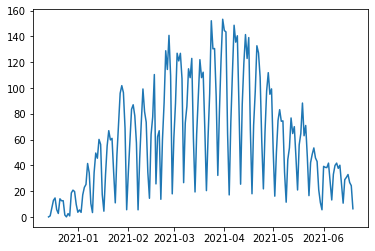

In [31]:
total_dose = vax_df.groupby("administration_date")['pop_perc'].sum().reset_index()
total_dose
plt.plot(total_dose.administration_date, total_dose.pop_perc)

In [32]:
vax_df.sort_values(['region','health_district', 'locality','administration_date'],
              inplace=True,ascending=True,ignore_index=True)

In [33]:
vax_df['weekly_rolling_avg_dose'] = vax_df.vaccine_doses_administered.rolling(7).mean()

In [34]:
vax_df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population,region,pop_perc,weekly_rolling_avg_dose
0,2020-12-15,51041,Chesterfield,Chesterfield,Hospitals,Moderna,1,1,343551,central,0.000291,NaN
1,2020-12-15,51041,Chesterfield,Chesterfield,Hospitals,Pfizer,1,52,343551,central,0.015136,NaN
2,2020-12-15,51041,Chesterfield,Chesterfield,Medical Practices,Pfizer,1,1,343551,central,0.000291,NaN
3,2020-12-16,51041,Chesterfield,Chesterfield,Medical Practices,Pfizer,1,9,343551,central,0.002620,NaN
4,2020-12-16,51041,Chesterfield,Chesterfield,Hospitals,Pfizer,1,309,343551,central,0.089943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
254291,2021-06-18,51141,Patrick,West Piedmont,Pharmacies,J&J,1,5,17748,southwest,0.028172,3.000000
254292,2021-06-18,51141,Patrick,West Piedmont,Other Community Health Providers,Moderna,1,1,17748,southwest,0.005634,3.000000
254293,2021-06-19,51141,Patrick,West Piedmont,Pharmacies,Pfizer,1,2,17748,southwest,0.011269,3.142857
254294,2021-06-19,51141,Patrick,West Piedmont,Pharmacies,J&J,1,3,17748,southwest,0.016903,2.857143


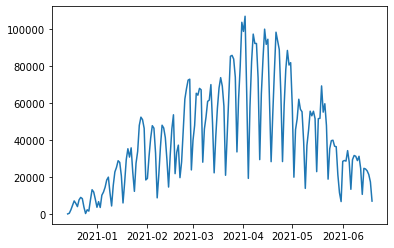

In [35]:
test = vax_df.groupby("administration_date").weekly_rolling_avg_dose.sum()
plt.plot(test)

In [36]:
vax_df.columns

Index(['administration_date', 'fips', 'locality', 'health_district',
       'facility_type', 'vaccine_manufacturer', 'dose_number',
       'vaccine_doses_administered', 'Population', 'region', 'pop_perc',
       'weekly_rolling_avg_dose'],
      dtype='object')

In [41]:
def preprocess_vax_df():
    """
    Preprocess the case_data from sql db and output as 3 dfs
    """
    # Access dataset from SQL db
    engine = create_engine('sqlite:///covid.db')
    df = pd.read_sql('SELECT v.*, p.Population FROM vaccine_data v LEFT JOIN pop_data p ON v.locality=p.Locality;'
                         ,engine)
    
    # Convert Datetime
    df['administration_date'] = pd.to_datetime(df.administration_date)
    df['vaccine_doses_administered'] = df.vaccine_doses_administered.astype(int)
    df.Population.fillna(0, inplace=True)
    df['Population'] = df.Population.astype(int)
    
    # Add Region column
    central=["Chesterfield", "Crater", "Chickahominy","Henrico","Piedmont","Richmond","Southside"]
    eastern = ["Chesapeake", "Eastern Shore", "Hampton", "Norfolk", "Peninsula", "Portsmouth", "Three Rivers", 
           "Virginia Beach", "Western Tidewater"]
    northern = ["Alexandria", "Arlington", "Fairfax", "Loudoun", "Prince William"]
    northwest = ["Central Shenandoah", "Lord Fairfax", "Rappahannock", "Rappahannock Rapidan", "Blue Ridge"]
    southwest = ["Alleghany", "Central Virginia", "Cumberland Plateau", "Lenowisco", "Mount Rogers", "New River",
            "Pittsylvania-Danville", "Roanoke", "West Piedmont"]
    other = ["Not Reported", "Out of State"]

    region_dict = {"central": central,
                 "eastern": eastern,
                 "northern": northern,
                 "northwest": northwest,
                 "southwest": southwest,
                 "other": other}
    region_map = {val:key for key, lst in region_dict.items() for val in lst}
    df['region'] = df.health_district.map(region_map)
    
    # separate out the federal doses
    other_df = df[df.Population == 0]
    county_df = df[df.Population != 0]
    
    # dose in population percentage
    county_df['pop_perc'] = county_df.vaccine_doses_administered / county_df.Population *100
    
    # weekly rolling avg doses
    county_df.sort_values(['region','health_district', 'locality','administration_date'],
              inplace=True,ascending=True,ignore_index=True)
    county_df['weekly_rolling_avg_dose'] = county_df.vaccine_doses_administered.rolling(7).mean()
    
    county_df = county_df[['administration_date',  'fips', 'region','health_district','locality', 'Population', 
                           'facility_type', 'vaccine_manufacturer', 'dose_number', 'vaccine_doses_administered',
                           'pop_perc','weekly_rolling_avg_dose']]
    return df, county_df, other_df

In [42]:
df, county_df, other_df = preprocess_vax_df()

In [43]:
df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population,region
0,2021-06-19,51001,Accomack,Eastern Shore,Local Health Departments,Moderna,1,3,32673,eastern
1,2021-06-19,51001,Accomack,Eastern Shore,Pharmacies,Moderna,2,1,32673,eastern
2,2021-06-19,51001,Accomack,Eastern Shore,Local Health Departments,J&J,1,1,32673,eastern
3,2021-06-19,51001,Accomack,Eastern Shore,Pharmacies,Moderna,1,3,32673,eastern
4,2021-06-19,51003,Albemarle,Blue Ridge,Hospitals,Pfizer,2,79,107405,northwest
...,...,...,...,...,...,...,...,...,...,...
261418,2020-12-14,51810,Virginia Beach,Virginia Beach,Medical Practices,Pfizer,1,1,450201,eastern
261419,2020-12-14,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,1,10,0,other
261420,2020-12-14,Out of State,Out of State,Out of State,Medical Practices,Pfizer,1,3,0,other
261421,NaT,Not Reported,Not Reported,Not Reported,Federal Doses,Non-Specified,2,199860,0,other


In [44]:
county_df

,administration_date,fips,region,health_district,locality,Population,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,pop_perc,weekly_rolling_avg_dose
0,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Moderna,1,1,0.000291,NaN
1,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Pfizer,1,52,0.015136,NaN
2,2020-12-15,51041,central,Chesterfield,Chesterfield,343551,Medical Practices,Pfizer,1,1,0.000291,NaN
3,2020-12-16,51041,central,Chesterfield,Chesterfield,343551,Medical Practices,Pfizer,1,9,0.002620,NaN
4,2020-12-16,51041,central,Chesterfield,Chesterfield,343551,Hospitals,Pfizer,1,309,0.089943,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
254291,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,J&J,1,5,0.028172,3.000000
254292,2021-06-18,51141,southwest,West Piedmont,Patrick,17748,Other Community Health Providers,Moderna,1,1,0.005634,3.000000
254293,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,Pfizer,1,2,0.011269,3.142857
254294,2021-06-19,51141,southwest,West Piedmont,Patrick,17748,Pharmacies,J&J,1,3,0.016903,2.857143


In [45]:
other_df

,administration_date,fips,locality,health_district,facility_type,vaccine_manufacturer,dose_number,vaccine_doses_administered,Population,region
606,2021-06-19,Not Reported,Not Reported,Not Reported,Medical Practices,Moderna,2,2,0,other
607,2021-06-19,Not Reported,Not Reported,Not Reported,Pharmacies,Pfizer,2,78,0,other
608,2021-06-19,Not Reported,Not Reported,Not Reported,Hospitals,J&J,1,1,0,other
609,2021-06-19,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,2,26,0,other
610,2021-06-19,Not Reported,Not Reported,Not Reported,Pharmacies,Moderna,1,15,0,other
...,...,...,...,...,...,...,...,...,...,...
261400,2020-12-15,Out of State,Out of State,Out of State,Hospitals,Pfizer,1,10,0,other
261419,2020-12-14,Not Reported,Not Reported,Not Reported,Medical Practices,Pfizer,1,10,0,other
261420,2020-12-14,Out of State,Out of State,Out of State,Medical Practices,Pfizer,1,3,0,other
261421,NaT,Not Reported,Not Reported,Not Reported,Federal Doses,Non-Specified,2,199860,0,other
